## Stacking Modeling 
In this notebook, we implemented and evaluated a Stacking model (RF and XGBoost as base learners, with Logistic regression as meta learner) to predict auto loan default (bad_flag).

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from preprocessing import load_data, preprocess_data
from model_evaluation import evaluate_models, tune_hyperparameters, feature_importance, threshold_analysis, cross_val_pr_curve, cross_val_roc_curve
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

## Load & Preprocess Data

In [22]:
train_path = "/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
eval_path = "/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"

df_train, df_eval = load_data(train_path, eval_path)
X_train_processed, y_train, X_eval_processed, y_eval, to_drop_corr, cols_to_drop, preprocessor = preprocess_data(df_train, df_eval)

print("Train shape:", X_train_processed.shape)
print("Eval shape:", X_eval_processed.shape)

Train shape: (21348, 28)
Eval shape: (5336, 28)


CV Scores: [0.98739069 0.98527908 0.98015479]
Mean CV Score: 0.9842748540089136
Classification Report:               precision    recall  f1-score   support

           0       0.11      0.76      0.19       958
           1       0.98      0.72      0.83     20390

    accuracy                           0.72     21348
   macro avg       0.55      0.74      0.51     21348
weighted avg       0.95      0.72      0.80     21348



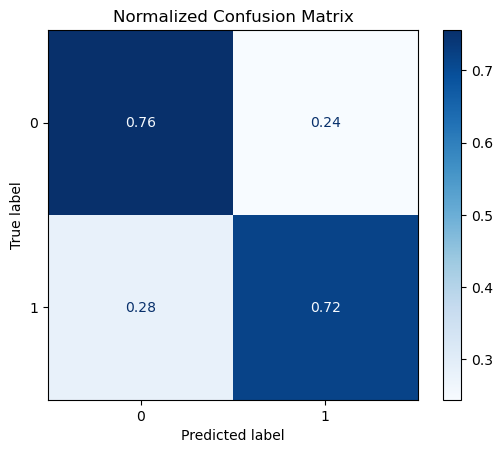

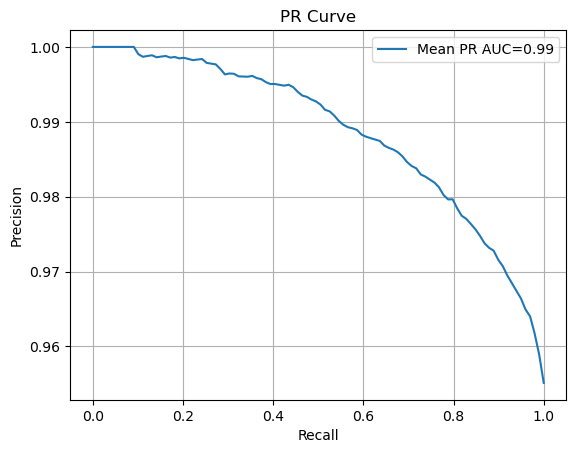

Mean PR AUC: 0.9886


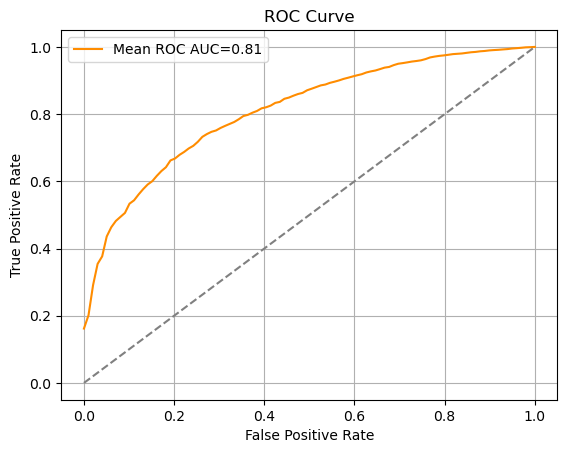

Mean ROC AUC: 0.8114

=== Final Evaluation on Test Set ===
              precision    recall  f1-score   support

           0       0.11      0.76      0.20       242
           1       0.98      0.71      0.83      5094

    accuracy                           0.72      5336
   macro avg       0.55      0.74      0.51      5336
weighted avg       0.94      0.72      0.80      5336



In [23]:
# Define base learners
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)

xgb_clf = xgb.XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=300,
    scale_pos_weight=0.3544383149448345,
    subsample=0.7,
    eval_metric='logloss',
    random_state=42
)

# Meta learner
meta_learner = LogisticRegression(max_iter=5000, class_weight='balanced')

# Stacking classifier
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_clf)],
    final_estimator=meta_learner,
    passthrough=True,
    cv=3,
    n_jobs=-1
)

# Convert to DataFrame if needed
X_train_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

# Evaluate the stacking model using your existing evaluation function
evaluate_models(stacking_model, X_train_df.to_numpy(), y_train)

# Evaluate on test set
y_eval_pred = ensemble_model.predict(X_eval_processed)
print("\n=== Final Evaluation on Test Set ===")
print(classification_report(y_eval, y_eval_pred))
